In [57]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input,optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float32'

In [2]:
# INIT
# PART 1
number_samples = [128, 256, 512, 1024, 2048, 4096] 
validation_size, noise_floor = 0.2, -110.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 299, 299, 3, 60  # su_size:30 for 1000, 10 for 100
cell_size, pixel_expansion = 1000 / max_x, max_x / 1000
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope, su_slope = 'log', 5, 6  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_pus_num, max_sus_num = 20, 5
propagation_model = 'log' # 'splat', 'log', 'testbed'
noise, std = True, 1 # False for splat
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = False
if sensors:
    sensors_num = 3600
    sensors_file_path = f"data/sensors/square{100}/{sensors_num}/sensors.txt"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 14
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '_transfer/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (f"{intensity_degradation}_pu{slope}_su{su_slope}")) + (
    "/" + str(sensors_num) + "sensors" if sensors else f"/{max_pus_num}pus") + \
        f"_{max_sus_num}sus_{number_image_channels}channels" + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [3]:
image_dir

'ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_3channels/images'

(array([8.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 9.0000e+00, 8.0000e+00, 7.0000e+00,
        1.1000e+01, 1.4000e+01, 9.0000e+00, 8.0000e+00, 2.0000e+01,
        2.1000e+01, 2.7000e+01, 2.1000e+01, 3.1000e+01, 3.4000e+01,
        3.6000e+01, 4.7000e+01, 4.5000e+01, 5.8000e+01, 7.0000e+01,
        8.9000e+01, 7.6000e+01, 8.9000e+01, 1.3000e+02, 1.3000e+02,
        1.5000e+02, 1.8100e+02, 1.9900e+02, 2.4700e+02, 2.9800e+02,
        2.9200e+02, 3.6500e+02, 4.2200e+02, 4.8400e+02, 5.1800e+02,
        6.3000e+02, 6.9200e+02, 8.0000e+02, 9.4100e+02, 1.0460e+03,
        1.3290e+03, 1.3630e+03, 1.6530e+03, 1.8990e+03, 2.2380e+03,
        2.4950e+03, 2.9400e+03, 3.2990e+03, 3.7140e+03, 4.2510e+03,
        4.8750e+03, 5.4950e+03, 6.1480e+03, 7.1260e+03, 7.8260e+03,
        8.8260e+03, 9.9200e+03, 1.1238e+04, 1.2423e+04, 1.3660e+04,
        1.5236e+04, 1.6496e+04, 1.8218e+04, 1.95

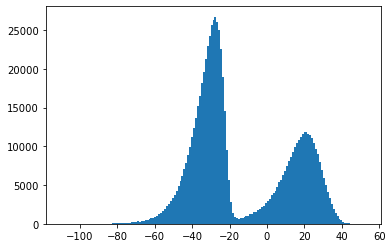

In [48]:
plt.hist(data_reg[:, -1], bins='auto')

In [4]:
# LOAD DATA
num_columns = (sensors_num if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 2
# num_columns = max_pus_num * 3 + 1 + max_sus_num * 3 + 2
cols = [i for i in range(num_columns)]
dataset_name = "dynamic_pus_using_pus_1000000_min10_max20PUs_min1_max5SUs_square1000grid_log_noisy_std1.0_2021_10_20_11_04.txt"
max_dataset_name = "dynamic_pus_max_power_1000000_min10_max20PUs_min1_max5SUs_square1000grid_log_noisy_std1.0_2021_10_20_11_04.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
    set_file.write(max_dataset_name)

dataframe = pd.read_csv('data/' 
                        + dataset_name, delimiter=',', header=None, names=cols)
dataframe_max = pd.read_csv('data/' 
                            + max_dataset_name, delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)
dataframe_max[dataframe_max.shape[1] - 1] = dataframe_max[dataframe_max.shape[1] - 1].astype(float)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]], axis=1,
                        ignore_index=True)

idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)

data_reg = dataframe_tot.values
data_reg[data_reg < noise_floor] = noise_floor

if sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe, dataframe_tot, dataframe_max

In [6]:
data_reg[0,:]

array([ 11.   ,  24.   ,  67.   ,  -0.827,  85.   ,  63.   ,  -1.445,
        27.   ,  38.   ,  -0.564,  65.   ,  50.   ,  -0.706,   6.   ,
        51.   ,  -0.444,  20.   ,  73.   , -12.873,  54.   ,  14.   ,
       -14.352,  66.   ,  19.   , -11.933,  51.   ,  78.   , -16.058,
        45.   ,  30.   ,  -3.931,   3.   ,  24.   , -22.74 ,  13.   ,
        86.   ,  78.   ,  31.057,  52.   ,  36.   , -35.9  ,  89.   ,
        76.   , -21.02 ,  23.   ,  43.   , -33.63 ,  31.   ,  78.   ,
       -50.41 ,  24.   ,  35.   , -31.88 ,  89.   ,  58.   , -20.66 ,
        89.   ,  68.   , -30.66 ,  14.   ,  23.   , -15.99 ,  28.   ,
        72.   , -26.95 ,  81.   ,  10.   , -14.29 ,   8.   ,  48.   ,
       -18.46 ,   2.   ,  65.   ,  40.961,   0.   ,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     

In [8]:
data_reg = data_reg[:30000][:]

In [6]:
data_reg = data_reg[:4000]

In [14]:
data_reg_train = data_reg[12000][:]

In [5]:
data_reg.shape

(750918, 79)

In [44]:
np.max(data_reg[:, -1])

33.652

In [6]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5 * cell_size

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle',
                 pu_param=None, su_shape='circle', su_param=None, intensity_degradation="log", 
                 max_pu_power: float=0, max_su_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((max_x, max_y, number_image_channels), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
                pu_p = data[pu_i * 3 + 3]
                pu_channel = int(abs(pu_p)//5)
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y),
                                             shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[int(abs(pu_p))//10][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][pu_channel] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][pu_channel] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_param, ss_shape = pu_param, pu_shape
            for ss_i in range(sensors_num):
                ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x * pixel_expansion))), max(
                    0, min(max_x-1, int(sensors_location[ss_i].y * pixel_expansion))), max(noise_floor, data[ss_i])
                ss_channel = 0 
#                 if -62.5 <= ss_p < -50.0:
#                     ss_channel = 1
#                 elif -70.0 <= ss_p < -62.6:
#                     ss_channel = 2
#                 elif -77.5 <= ss_p < -70.0:
#                     ss_channel = 3
#                 elif -85.0 <= ss_p < -77.5:
#                     ss_channel = 4
# #                 elif -70.0 <= ss_p < -65.0:
# #                     ss_channel = 5
#                 elif ss_p < -85.0:
#                     ss_channel = 5
                if -70 <= ss_p < -60.0:
                    ss_channel = 1
                elif -80.0 <= ss_p < -70:
                    ss_channel = 2
                elif -90.0 <= ss_p < -80.0:
                    ss_channel = 3
                elif -100.0 <= ss_p < -90.0:
                    ss_channel = 4
                elif ss_p < -100.0:
                    ss_channel = 5
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[point.p.x][point.p.y][ss_channel] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][ss_channel] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][ss_channel] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1] * pixel_expansion)))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2] * pixel_expansion)))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            su_param_p = get_pu_param(su_shape, intensity_degradation, su_p, noise_floor, su_slope)
            points = points_inside_shape(center=Point(su_x, su_y),
                                         param=su_param_p, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -2
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - su_slope * point.dist - noise_floor)/(max_su_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_su_power - noise_floor)
                        else:
                            su_val = (su_p - su_slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_su_power - noise_floor)
                    image[point.p.x][point.p.y][su_channel] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1] * pixel_expansion)))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2] * pixel_expansion)))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y),
                                     param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[point.p.x][point.p.y][su_channel] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        pus_num = int(data[0])
        for pu_i in range(pus_num):
            pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
            pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
            pu_p = data[pu_i * 3 + 3]
            
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                            max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        else:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
#                                 max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        
        # creating SU image
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
            
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image       
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-int(r/cell_size), -max_x), 
                             min(int(r/cell_size), max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num, image_dir=image_dir):
    if False and style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
        suffix = 'npz'  # npy, npz
        image = np.load(f"{image_dir}{image_num//100000}/image{image_num}.{suffix}") 
#         image = np.load(f"{image_dir}/image{image_num}.{suffix}") 
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image

In [186]:
data_img_train[0] = image

In [11]:
train_size = 2048
data_reg_train = np.repeat(data_reg[:train_size], 4, axis=0)
image_state = ["", "rot", "lr", "ud"] * train_size
p = np.random.permutation(train_size*4)
data_reg_train = data_reg_train[p]
new_image_state = []
for idx in range(train_size*4):
    new_image_state.append(image_state[p[idx]])

In [12]:
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg_train[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0 if not sensors else -60)
        if new_image_state[image_num] == "rot":
            image = np.rot90(image, 2)
        elif new_image_state[image_num] == "lr":
            image = np.fliplr(image)
        elif new_image_state[image_num] == "ud":
            image = np.flipud(image)
        np.savez_compressed(image_dir + '/aug/image' + str(image_num), a=np.expand_dims(image,0 ))
        
        del image

In [15]:
jobs = []
proc_sizes = [data_reg_train.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg_train.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|█████████████████████████████████████████| 585/585 [06:38<00:00,  1.47it/s]


In [7]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0 if not sensors else -60,
                            max_su_power=50.0)
        if False and style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
    #         np.save(image_dir + '/image' + str(image_num), image)
#             np.savez_compressed(f"{image_dir}{(600000 + image_num)//100000}/image{600000 + image_num}",
#                                 a=np.expand_dims(image,0))
            np.savez_compressed(f"{image_dir}/image{image_num}",
                                a=np.expand_dims(image,0))
        del image

In [14]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|███████████████████████████████████████| 1366/1366 [07:07<00:00,  3.19it/s]


In [21]:
data_reg[2,:]

array([ 11.   ,   4.   ,  25.   ,  -6.818,  35.   ,  95.   ,  -0.287,
        60.   ,  90.   , -26.266,  86.   ,  89.   ,  -5.14 ,  52.   ,
        70.   , -20.486,   1.   ,  35.   ,  -2.297,   5.   ,   6.   ,
       -17.296,   3.   ,  69.   ,  -2.296,  27.   ,  35.   ,  -6.15 ,
        96.   ,  62.   ,  -5.406,  12.   ,  54.   ,  -5.032,   3.   ,
        71.   ,  55.   ,  17.339,  27.   ,  72.   , -45.29 ,  61.   ,
        59.   ,  10.213,   0.   ,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan, -48.57 ])

In [14]:
imm = read_image(5876)
new_imm = np.zeros((max_x, max_y), dtype=float_memory_used)
for x in range(max_x):
    for y in range(max_y):
        new_imm[x][y] = imm[0][x][y][-1]

In [47]:
np.max(data_reg[:,-1])

52.733

In [51]:
imm = read_image(123853, image_dir=f"{image_dir}")#, image_dir="/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/images")
immm = np.zeros((max_x, max_y, number_image_channels), dtype='float')
for x in range(max_x):
    for y in range(max_y):
        for ch in range(number_image_channels):
            immm[x][y][ch] = float(imm[0][x][y][ch])

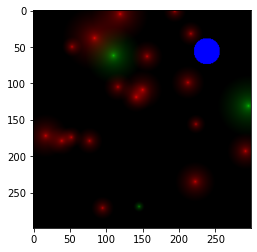

In [52]:
immm[immm>1] = 1.0
plt.imshow(immm)

In [ ]:
## immm[immm>1] = 1.0
plt.imshow(immm)

In [53]:
data_reg[123853,:]

array([ 18.   , 354.   , 390.   , -19.364, 576.   ,  58.   ,  -9.907,
       599.   , 258.   , -20.74 ,  20.   , 400.   ,  -4.138, 211.   ,
       525.   , -17.087, 128.   , 281.   ,  -1.366, 583.   , 174.   ,
       -25.391,   4.   , 652.   , -24.062, 908.   , 320.   , -23.922,
       787.   , 745.   , -11.667, 600.   , 132.   , -19.211, 524.   ,
       747.   , -27.618, 109.   , 725.   , -22.43 , 401.   , 472.   ,
       -17.669, 648.   , 975.   , -13.688, 367.   , 504.   , -12.27 ,
       169.   , 178.   , -27.046, 332.   , 711.   , -15.598,   4.   ,
       441.   , 987.   ,  19.228, 209.   , 369.   ,  17.036, 902.   ,
       486.   , -25.329, 190.   , 799.   ,  48.603,   0.   ,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan, -26.59 ])

In [17]:
rotated_im = np.rot90(immm, 2)

In [102]:

img_rot = ndimage.rotate(immm, -90, reshape=False)
img_rot = np.rot90(immm,2)
plt.imshow(img_rot)


NameError: name 'ndimage' is not defined

<AxesSubplot:>

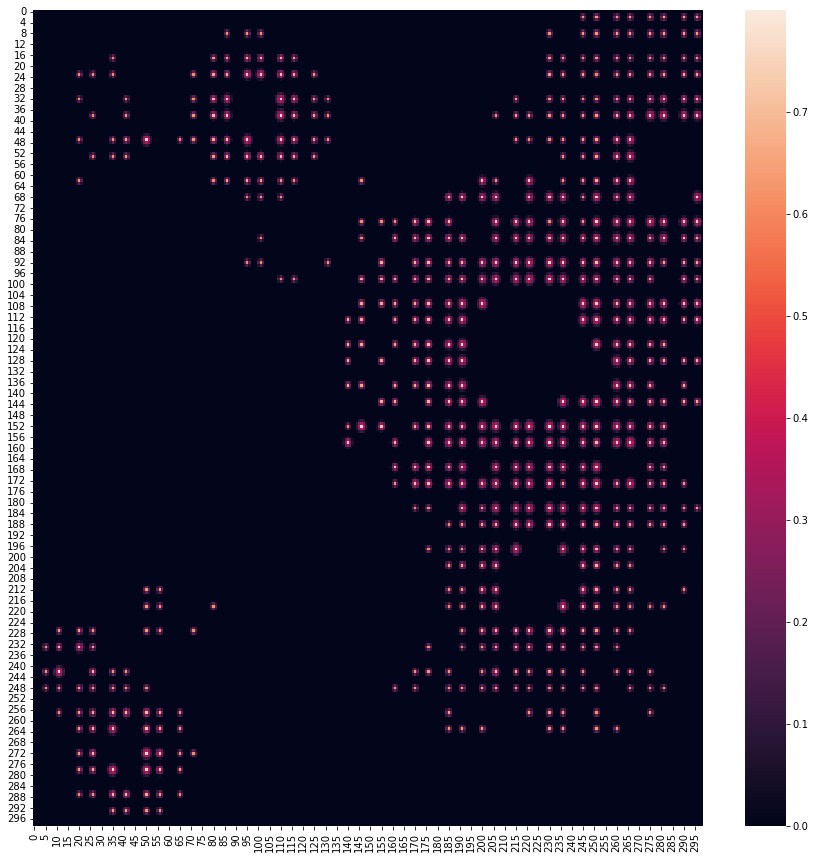

In [22]:

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(immm[:,:,2], ax=ax)

In [7]:
def cnn_model(kernel_lam, bias_lam):
    inputs = Input(shape=(max_x, max_y, number_image_channels))
    convolution_filter, dense_filter = 'relu', 'linear'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.
#     base_model.trainable = False
    cnn = base_model(inputs, training=True)
#     cnn = base_model(inputs)
    
#     cnn = layers.Dense(1024, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
#                              bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
#     cnn = layers.Dropout(0.5)(cnn)
    if True:
        # Convert features of shape `base_model.output_shape[1:]` to vectors
        cnn = layers.GlobalAveragePooling2D()(cnn)
        cnn = layers.Dense(2048, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
        cnn = layers.Dropout(0.5)(cnn)
        outputs = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init)(cnn)
        return Model(inputs, outputs)
    else:
        data_format="channels_last"
        filter_shape, pool_size = (1, 1), (2,2)
        cnn = layers.Conv2D(512, filter_shape, padding='same', 
                            activation=convolution_filter, data_format=data_format, 
                            kernel_regularizer=regularizers.l2(kernel_lam), 
                            bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(128, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(32, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(8, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(1, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.GlobalAveragePooling2D()(cnn)
        return Model(inputs, cnn)
    

class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, image_dir = image_dir, conserve=0):
#         print(dataset.shape[0])
#         print("generator initiated")
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
        self._image_dir = image_dir
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
#         print('generator yielded a batch %d' % idx)
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.max_x, self.max_y, self.number_image_channels), dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i, self._image_dir)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)


In [40]:
# Xception model
model_name = "vgg16"
base_model = applications.VGG16(include_top=False, weights=None,
                                input_shape=(max_x, max_y, number_image_channels))
base_model.trainable = True
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [9]:
# log-vgg pretrained - pu-setting
model_name = "log_vgg16"
fp_penalty_coef, fn_penalty_coef = 1, 1
base_model = models.load_model("ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/" + 
                               "raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels_700k/models/700000/" +
                               "best_model_lambda_0_fit.h5", 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
base_model.trainable = False
base_model = base_model.layers[1]
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [17]:
# log-vgg pretrained - ss-setting
model_name = "log_vgg16"
fp_penalty_coef, fn_penalty_coef = 1, 1
base_model = models.load_model("ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/" + 
                               "raw_power_min_max_norm/color/log_pu5_su6/3600sensors_5_sus_8_channels_700k/models/" +
                               "vgg16/700000/best_model_lambda_0.1_fit.h5", 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
base_model.trainable = False
base_model = base_model.layers[1]
base_model.summary()

2021-10-29 23:07:54.228736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 23:07:54.232788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 23:07:54.233095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 23:07:54.233571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 299, 299, 8)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      4672      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [41]:
cnn1 = cnn_model(0, 0)

In [42]:
cnn1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2049      
Total params: 15,767,361
Trainable params: 15,767,361
Non-trainable params: 0
_______________________________________________

In [23]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
number_samples = [128, 256, 512, 1024, 2048, 4096]

In [20]:
number_samples = [train_size]

In [43]:
number_samples = [700000]

In [60]:
# CNN: support batching
TEST, CONSERVE = True, False
mini_batch = 16 if max(max_x, max_y) == 1000 else 32
epochs = 35 if max(max_x, max_y) == 1000 else 100
MAX_QUEUE_SIZE, WORKERS = 28, 4
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0] 
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
    if CONSERVE:
        data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1.5 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + model_name + "/" + (
        "conservative/" if CONSERVE else "") + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(), 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb in lambda_vec]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb in lambda_vec]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
                                        image_dir=f"{image_dir}")
    

    val_size = math.ceil(number_sample * validation_size)
    val_size = data_reg.shape[0] - number_sample
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=2,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
    # ******************** fine-tunning *******
    print("******FINE TUNNING ******")
    # reloading the best
    cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'}) for lamb in lambda_vec]
    for cnn in cnns:
        cnn.trainable = True
        cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                    optimizer=optimizers.Adam(1e-4), 
                    metrics=['mse', 'mae', fp_mae])
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
                                        image_dir=f"{image_dir}")
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=int(epochs//2), verbose=2,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
    
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(lambda_vec[best_lamb_idx]) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/models/' + model_name + "/"
                     + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve,
                     checkpointers],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 700000 , New samples: 700000
Validation size: 50918 , starts: 700000 , ends: 750917
Epoch 1/100
21875/21875 - 3761s - loss: 739.6440 - mse: 739.6440 - mae: 25.1473 - fp_mae: 15.5063 - val_loss: 693.8832 - val_mse: 693.8832 - val_mae: 23.9291 - val_fp_mae: 12.3199

Epoch 00001: val_mae improved from inf to 23.92910, saving model to ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_3channels/models/vgg16/700000/best_model_lambda_0.h5
Epoch 2/100
21875/21875 - 3754s - loss: 688.6730 - mse: 688.6730 - mae: 23.6880 - fp_mae: 11.9247 - val_loss: 693.3735 - val_mse: 693.3735 - val_mae: 23.7440 - val_fp_mae: 11.8439

Epoch 00002: val_mae improved from 23.92910 to 23.74405, saving model to ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_3channels/models/vgg16/700000/best_model_lambda_0.h5
Epoch 3/100
21875/21875 - 3763s - loss: 6

KeyboardInterrupt: 

In [25]:
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)

[6.97, 6.86, 6.966, 6.76, 6.707, 6.671]
[3.172, 2.917, 2.801, 2.854, 2.958, 2.772]
[0.1, 10, 10, 1, 1, 0.1]


In [26]:
MODEL_PATH

'ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_3channels/models/resnet50/700000/best_model_lambda_'

In [27]:
cnns[0].save(MODEL_PATH + "0_fit.h5")

/home/shahrokh/miniconda3/envs/research/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [37]:
a = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ii, jj = 2, 2
b = [a[i][j] for i in range(max(0, ii - 1), min(2, ii+1) + 1) for j in range(max(0, jj-1), min(2, jj+1)+1)
     if not (i ==ii and j==jj)]

In [43]:
c = {1:2, 3:4}
[c[i] for i in c]

[2, 4]

In [25]:
#### MULTIPLE - SUS
def db_to_dec(db: float):
    return 10 ** (db/10)
def dec_to_db(dec: float):
    return -float('inf') if dec <= 0 else 10 * math.log10(dec)

def greedy_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    # pus: (x, y, p), requesting_sus: (x, y)
    def best_su_candidate(pus, active_sus, requesting_sus):
        if len(requesting_sus) == 1:
            return requesting_sus[0][0]
        # active_sus: (x, y, allocated_power), requesting_sus: (req_id, x, y)
        power_map_cell_size, area_size = 50, 1000
        cell_weight, neighbour_weight = 0.5, 0.5
        power_map = [[0] * int(area_size // power_map_cell_size) for _ in range(int(area_size // power_map_cell_size))]
        
        for pu_num in range(int(len(pus)//3)):
            x, y, dec_p = pus[pu_num*3], pus[pu_num * 3 + 1], db_to_dec(pus[pu_num*3 + 2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        for su in active_sus:
            x, y, dec_p = su[0], su[1], db_to_dec(su[2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        
        power_score = [[0] * len(power_map[0]) for _ in range(len(power_map))]
        # updating power score
        for i in range(len(power_map)):
            for j in range(len(power_map[0])):
                power_score[i][j] = cell_weight * power_map[i][j] + neighbour_weight * sum(
                [power_map[ii][jj] for ii in range(max(0, i - 1), min(i + 1, len(power_map))) 
                 for jj in range(max(0, j - 1), min(j + 1, len(power_map[0]))) if not (i == ii and j == jj)])
        # find su with lowest weight
        best_su_req, min_score = -1, float('inf')
        for req_id, x, y in requesting_sus:
            if power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)] < min_score:
                min_score = power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)]
                best_su_req = req_id
        return best_su_req         
    active_sus = [{} for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for _ in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            nex_req_id = best_su_candidate(pus, [(*requesting_sus[i], active_sus[ch][i]) for i in active_sus[ch]],
                                          [(idd, *requesting_sus[idd]) for idd in range(len(requesting_sus))
                                           if idd not in assigned_req])
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res

def fair_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    # pus: (x, y, p), requesting_sus: (x, y)
    def best_su_candidate(pus, active_sus, requesting_sus):
        if len(requesting_sus) == 1:
            return requesting_sus[0][0]
        # active_sus: (x, y, allocated_power), requesting_sus: (req_id, x, y)
        power_map_cell_size, area_size = 50, 1000
        cell_weight, neighbour_weight = 0.5, 0.5
        power_map = [[0] * int(area_size // power_map_cell_size) for _ in range(int(area_size // power_map_cell_size))]
        
        for pu_num in range(int(len(pus)//3)):
            x, y, dec_p = pus[pu_num*3], pus[pu_num * 3 + 1], db_to_dec(pus[pu_num*3 + 2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        for su in active_sus:
            x, y, dec_p = su[0], su[1], db_to_dec(su[2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        
        power_score = [[0] * len(power_map[0]) for _ in range(len(power_map))]
        # updating power score
        for i in range(len(power_map)):
            for j in range(len(power_map[0])):
                power_score[i][j] = cell_weight * power_map[i][j] + neighbour_weight * sum(
                [power_map[ii][jj] for ii in range(max(0, i - 1), min(i + 1, len(power_map))) 
                 for jj in range(max(0, j - 1), min(j + 1, len(power_map[0]))) if not (i == ii and j == jj)])
        # find su with lowest weight
        best_su_req, min_score = -1, float('inf')
        for req_id, x, y in requesting_sus:
            if power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)] < min_score:
                min_score = power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)]
                best_su_req = req_id
        return best_su_req         
    active_sus = [{} for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for _ in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            nex_req_id = best_su_candidate(pus, [(*requesting_sus[i], active_sus[ch][i]) for i in active_sus[ch]],
                                          [(idd, *requesting_sus[idd]) for idd in range(len(requesting_sus))
                                           if idd not in assigned_req])
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        if max_allocated_power < -20:
            # it's less than threshold. sort active su w.r.t to best_req_id and try to decrease their power
            def dist(p1, p2):
                return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
            dist_info = []
            for ch in range(number_channel):
                for i in active_sus[ch]:
                    dist_info.append((ch, i, dist(requesting_sus[i], requesting_sus[best_req_id])))
            dist_info.sort(key=lambda x:x[2])
            SATISFIED = False
            for i in range(len(dist_info)):
                candid_ch, candid_su_id  = dist_info[i][0], dist_info[i][1]
                candid_old_pow = active_sus[candid_ch][candid_su_id]
                if  candid_old_pow > -10:
                    candid_new_pow = candid_old_pow
                    while candid_new_pow - 5 > -20.0:
                        candid_new_pow -= 5
                        # try this new power
                        su_lst = []
                        for ii in active_sus[candid_ch]:
                            su_lst += [*requesting_sus[ii]]
                            if ii == candid_su_id:
                                su_lst.append(candid_new_pow)
                            else:
                                su_lst.append(active_sus[candid_ch][ii])
                        requesting_data = [len(pus)//3] + pus + [len(active_sus[candid_ch]) + 1] + su_lst + requesting_sus[best_req_id]
                        requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                                       noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                                       su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                                       intensity_degradation=intensity_degradation, 
                                                                       max_pu_power=0.0 if not sensors else -30,
                                                                       max_su_power=0.0), 0)
                        predicted_power = model.predict(requesting_image)[0][0]
                        if predicted_power > -20.0:
                            SATISFIED = True
                            break
                    if SATISFIED:
                        break
            if SATISFIED:
                best_channel, max_allocated_power = candid_ch, predicted_power
                active_sus[candid_ch][candid_su_id] = candid_new_pow  #update the candid su
                    
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res

#     return [(i, active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     req_dec_power = [db_to_dec(active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     return sum(req_dec_power), max(req_dec_power) / min(req_dec_power)

def random_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    active_sus = [{}  for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for nex_req_id in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res
#     return [(req_id, active_sus[ch][req_id], ch) for req_id in active_sus[ch] for ch in range(number_channel)]
#     req_dec_power = [db_to_dec(active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     return sum(req_dec_power), max(req_dec_power) / min(req_dec_power)
    
def multiple_sus(data_reg, train_set_size, pl_info, model_path, number_channel):
#     random_sum_power, random_max_min_ratio = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
#     greedy_sum_power, greedy_max_min_ratio = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
    random_res, greedy_res = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
    fair_res = [[] for _ in range(len(train_set_size))]
    for ind, train_size in enumerate(train_set_size):
        print(f"Train size: {train_size}")
        model = models.load_model(f"{model_path}/{train_size}/best_model_lambda_0.1.h5",
                                 custom_objects={ 'loss': custom_loss(1, 1), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
        for i in tqdm.tqdm(range(len(data_reg))):
            pu_num = int(data_reg[i][0])
            pus = np.ndarray.tolist(data_reg[i][1:1 + pu_num * 3])
            su_num = int(data_reg[i][1 + pu_num * 3])
            if su_num < 4:
                continue
            sus = []
            for su_ind in range(su_num):
                sus.append(np.ndarray.tolist(data_reg[i][2 + pu_num * 3 + su_ind * 3:4 + pu_num * 3 + su_ind * 3]))
#             random_tot_power, random_ratio = random_sus(pus, sus, model, pl_info, 1)
#             print(random_tot_power)
#             print(random_ratio)
#             greedy_tot_power, greedy_ratio = greedy_sus(pus, sus, model, pl_info, 1)
#             print(greedy_tot_power)
#             print(greedy_ratio)
#             random_sum_power[ind].append(random_tot_power)
#             random_max_min_ratio[ind].append(random_ratio)
#             greedy_sum_power[ind].append(greedy_tot_power)
#             greedy_max_min_ratio[ind].append(greedy_ratio)
            fair_res[ind].append(fair_sus(pus, sus, model, pl_info, number_channel))
            random_res[ind].append(random_sus(pus, sus, model, pl_info, number_channel))
            greedy_res[ind].append(greedy_sus(pus, sus, model, pl_info, number_channel))
            var_f = open('/'.join(image_dir.split('/')[:-1]) + "/multi_res_num_channel"
                     + str(number_channel) + "_" + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
            pickle.dump([random_res, greedy_res, fair_res],  file=var_f)
            var_f.close()
            
#     return random_sum_power, random_max_min_ratio, greedy_sum_power, greedy_max_min_ratio
    return random_res, greedy_res, fair_res

In [16]:
rand_res, greedy_res, fair_res = multiple_sus(data_reg[:600], number_samples, None,
                                              "ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels/models/log_vgg16",
                                              4)

Train size: 128


  0%|                                       | 1/600 [03:01<30:11:50, 181.49s/it]


KeyboardInterrupt: 

In [35]:
rand_res, greedy_res, fair_res = pickle.load( open( "ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/pus_20_sus_3_channels/multi_res_num_channel1_log_5__202110_2115_18.dat", "rb" ) )

In [33]:
def multi_calc(data_arr):
    min_data, tot_power = [], []
    for data in data_arr:
#         min_arr = [min(val, key=lambda x:x[1])[1] for val in data]
        min_arr = [(sorted(val, key=lambda x:x[1])[-1][1] - sorted(val, key=lambda x:x[1])[0][1]) for val in data]
#         print(min_arr)
        min_data.append(sum(min_arr)/len(min_arr))
        sum_arr = [dec_to_db(sum([db_to_dec(val[1]) for val in fair_res_sng]))for fair_res_sng in data]
        tot_power.append(sum(sum_arr)/len(sum_arr))
    return [round(min_, 2) for min_ in min_data], [round(tot,2) for tot in tot_power]

In [46]:
fair_res

[[[(1, -10.144024848937988, 0),
   (0, -16.987225, 0),
   (3, -20.412891, 0),
   (2, -23.145056, 0)],
  [(0, -13.095824718475342, 0),
   (1, -32.571083, 0),
   (3, -25.243528, 0),
   (4, -19.01852, 0),
   (2, -25.115812, 0)],
  [(1, -16.26324462890625, 0),
   (2, -18.658442, 0),
   (3, -17.14082, 0),
   (0, -18.40398, 0),
   (4, -19.236364, 0)],
  [(0, -12.909529209136963, 0),
   (1, -16.141129, 0),
   (4, -21.618767, 0),
   (2, -20.870632, 0),
   (3, -31.694372, 0)],
  [(0, -2.181763172149658, 0),
   (2, -17.193947, 0),
   (1, -17.270231, 0),
   (3, -16.257801, 0)],
  [(4, -12.19670057296753, 0),
   (2, -19.228971, 0),
   (3, -23.723465, 0),
   (0, -25.837965, 0),
   (1, -30.800262, 0)],
  [(0, 4.8595414, 0),
   (1, -17.794598, 0),
   (4, -26.13981, 0),
   (2, -25.201769, 0),
   (3, -40.9086, 0)],
  [(0, -0.3474416732788086, 0),
   (1, -17.556076, 0),
   (4, -16.599995, 0),
   (2, -22.222687, 0),
   (3, -22.701294, 0)],
  [(0, 3.4885168075561523, 0),
   (1, -18.986036, 0),
   (3, -20.

In [39]:
minn, tot = multi_calc(fair_res)
print(minn)
print(tot)

[43.89, 44.01, 53.13, 49.15, 44.48, 37.25]
[-5.45, -3.14, 4.12, 5.55, 0.62, -0.84]


In [40]:
minn, tot = multi_calc(greedy_res)
print(minn)
print(tot)

[61.41, 57.23, 56.24, 52.25, 53.8, 50.12]
[6.08, 7.33, 6.52, 8.11, 7.9, 8.42]


In [41]:
minn, tot = multi_calc(rand_res)
print(minn)
print(tot)

[61.98, 56.99, 55.99, 51.97, 53.37, 49.66]
[5.87, 6.61, 5.7, 7.22, 7.36, 7.83]


In [122]:
[dec_to_db(sum([db_to_dec(x) for x in [xx] * 4])) for xx in [6.29, 7.17, 6.3, 7.8, 7.95, 8.07]]

[12.310599913279622,
 13.190599913279623,
 12.320599913279624,
 13.820599913279622,
 13.970599913279624,
 14.090599913279625]

In [279]:
greedy_res

[[[(1, 9.855975, 0), (2, -17.469374, 0), (3, 8.220337, 1), (0, 9.016077, 2)]],
 [[(1, 12.940007, 0),
   (2, -15.531879, 0),
   (3, 11.591465, 1),
   (0, 12.039752, 2)]],
 [[(1, 13.6573515, 0),
   (2, -22.402876, 0),
   (3, 11.080728, 1),
   (0, 12.62262, 2)]],
 [[(1, 14.943089, 0),
   (2, -21.386776, 0),
   (3, 12.000742, 1),
   (0, 12.803817, 2)]],
 [[(1, 6.529112, 0),
   (2, -23.809036, 0),
   (3, 11.771731, 1),
   (0, 12.140317, 2)]],
 [[(1, 6.734869, 0),
   (2, -25.894993, 0),
   (3, 11.733804, 1),
   (0, 13.858876, 2)]]]

In [ ]:
[[10609.339866896524],
 [27745.525760029166],
 [33981.2176874612],
 [83093.78437330532],
 [230199.57169850808],
 [303634.6974403381]]

In [53]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)

[128, 256, 512, 1034, 2048, 4096]
[8.678, 7.595, 7.392, 6.968, 6.75]
[5.619, 4.375, 3.38, 3.669, 3.312]
[0.1, 0, 1, 10, 0.1]


In [ ]:
[128, 256, 512, 1024, 2048, 4096]
[8.678, 7.595, 7.392, 6.968, 6.701, 6.521]
[5.619, 4.375, 3.38,  4.032, 3.282, 3.4]
[0.1, 0, 1, 10, 0.1 0.1]

In [43]:
cnns[0].summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_41  (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_41 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
________________________________________

In [128]:
base_model.trainable = True

In [140]:
cnns[0].summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_25  (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
________________________________________

In [53]:
mini_batch

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 299, 299, 8)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14717568  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1025      
Total params: 15,243,905
Trainable params: 15,243,905
Non-trainable params: 0
_______________________________________________

In [31]:
val_size

50918

In [30]:
train_generator = DataBatchGenerator(dataset=data_reg[0:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

# val_size = math.ceil(number_sample * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                   batch_size=32,
                                   start_idx=number_sample,
                                   number_image_channels=number_image_channels,
                                   max_x=max_x, max_y=max_y, 
                                   float_memory_used=float_memory_used,
                                  )

In [246]:
train_generator = DataBatchGenerator(dataset=data_reg_train[prev_sample:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

val_size = math.ceil(number_sample/4 * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample//4:number_sample//4+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample//4,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

In [40]:
MODEL_PATH

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/2048/best_model_lambda_'

In [37]:
best_model = models.load_model(MODEL_PATH + str(0) + '.h5', 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
best_model.layers[1].trainable = True
best_model.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(1e-5), 
                        metrics=['mse', 'mae', fp_mae])

In [38]:
best_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 10, 10, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 2049      
Total params: 27,763,201
Trainable params: 27,717,761
Non-trainable params: 45,440
__________________________________________

In [39]:
best_model.fit(train_generator, epochs=40, verbose=2,
                   validation_data=val_generator, 
                   shuffle=True, callbacks=[checkpointers[0]], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False)

Epoch 1/40
43750/43750 - 3162s - loss: 216.4403 - mse: 216.4403 - mae: 10.0242 - fp_mae: 5.0201 - val_loss: 233.9729 - val_mse: 233.9729 - val_mae: 10.0437 - val_fp_mae: 5.0807

Epoch 00001: val_mae improved from 10.20495 to 10.04367, saving model to ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_3channels/models/resnet50/700000/best_model_lambda_0.h5


/home/shahrokh/miniconda3/envs/research/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/40
43750/43750 - 3158s - loss: 213.3030 - mse: 213.3030 - mae: 9.9057 - fp_mae: 4.9567 - val_loss: 234.5021 - val_mse: 234.5021 - val_mae: 10.0220 - val_fp_mae: 5.0534

Epoch 00002: val_mae improved from 10.04367 to 10.02198, saving model to ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_3channels/models/resnet50/700000/best_model_lambda_0.h5
Epoch 3/40
43750/43750 - 3162s - loss: 211.8673 - mse: 211.8673 - mae: 9.8510 - fp_mae: 4.9315 - val_loss: 234.9513 - val_mse: 234.9513 - val_mae: 10.0127 - val_fp_mae: 5.0276

Epoch 00003: val_mae improved from 10.02198 to 10.01270, saving model to ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_3channels/models/resnet50/700000/best_model_lambda_0.h5
Epoch 4/40
43750/43750 - 3159s - loss: 210.7211 - mse: 210.7211 - mae: 9.8117 - fp_mae: 4.9084 - val_loss: 235.3171 - val_mse: 235.3171 - 

KeyboardInterrupt: 

In [68]:
MODEL_PATH

'ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/3600sensors_5_sus_8_channels/models/vgg16/700000/best_model_lambda_'

In [70]:
best_model.save(MODEL_PATH + "0.1_fit2.h5")

In [27]:
best_model.save("ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/700000/best_model_lambda_0_fit.h5")

In [53]:
MODEL_PATH

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/log_vgg16/1024/best_model_lambda_'

In [62]:
number_sample + val_size+320*3

2189

In [22]:
best_model1 = models.load_model(MODEL_PATH + str(0.1) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                    batch_size=32,
                                    start_idx=number_sample + val_size, 
                                    number_image_channels=number_image_channels,
                                    max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
                                   image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_model1.evaluate(test_generator, verbose=1, 
                                workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
test_mae_idx, test_fp_mae_idx = [best_model1.metrics_names.index(mtrc) 
                                for mtrc in ['mae','fp_mae']]
test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
average_diff_power.append(round(test_mae, 3))
fp_mean_power.append(round(test_fp_mae, 3))
print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
        fp_mean_power[-1])

Test starts:  2458 , ends:  19026
518/518 [==============================] - 74s 142ms/step - loss: 88.6073 - mse: 79.2132 - mae: 7.0449 - fp_mae: 3.4216
average_error:  7.045 , fp_average_error:  3.422


In [149]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     